First 5 rows of the dataset:
   pitch_id  game_id  season        date  home_team_id home_team_name  \
0   1242036    54842    2021  2021-04-01             6   Chicago Cubs   
1   1242037    54842    2021  2021-04-01             6   Chicago Cubs   
2   1242038    54842    2021  2021-04-01             6   Chicago Cubs   
3   1242039    54842    2021  2021-04-01             6   Chicago Cubs   
4   1242040    54842    2021  2021-04-01             6   Chicago Cubs   

   away_team_id      away_team_name  venue_id  pitch_number  ...  \
0            22  Pittsburgh Pirates        29             1  ...   
1            22  Pittsburgh Pirates        29             2  ...   
2            22  Pittsburgh Pirates        29             3  ...   
3            22  Pittsburgh Pirates        29             4  ...   
4            22  Pittsburgh Pirates        29             5  ...   

     pitcher_name batter_id   batter_name pre_pitch_inning  is_top_half  \
0  Kyle Hendricks      5199  Adam Frazier       

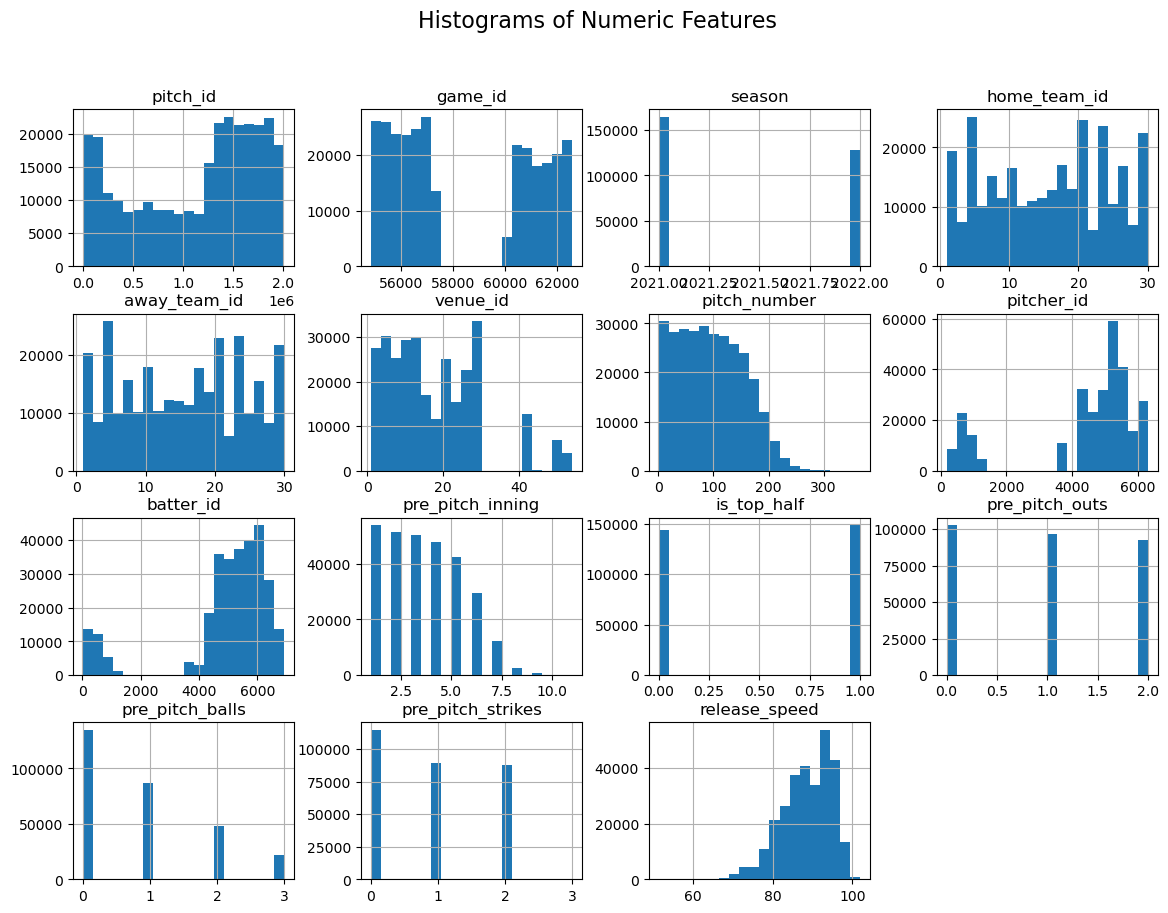

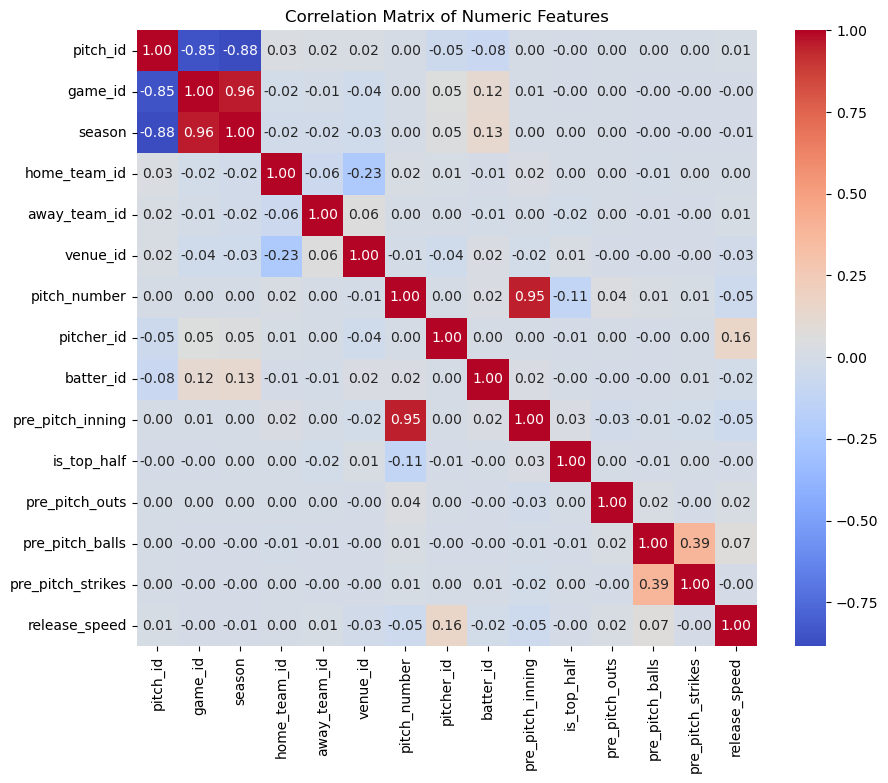

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '../../data/Fanduel_Data_Scientist_2025/mlb_pitch_velo_assessment.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the dataframe (data types, non-null counts, etc.)
print("\nDataset Info:")
print(df.info())

# Generate summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Assuming there's a column with the first pitch velocity, let's say it's named 'first_pitch_velo'
# Create a binary target variable: 1 if first pitch > 89.95 mph, 0 otherwise.
if 'first_pitch_velo' in df.columns:
    df['fast_first_pitch'] = (df['first_pitch_velo'] > 89.95).astype(int)
else:
    print("Note: 'first_pitch_velo' column not found. Please check your dataset columns.")

# Visualize the distribution of the binary target variable if it was created
if 'fast_first_pitch' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='fast_first_pitch', data=df)
    plt.title('Distribution of Fast First Pitch (> 89.95 mph)')
    plt.xlabel('Fast First Pitch (1: Yes, 0: No)')
    plt.ylabel('Count')
    plt.show()

# Additional EDA: Plotting histograms for all numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numeric Features', fontsize=16)
plt.show()

# Optionally: Explore correlations among numeric features
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [11]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set up logging configuration. In main(), we adjust the level based on debug flag.
logging.basicConfig(format='[%(levelname)s] %(message)s')


def load_data(file_path: str, debug: bool = False) -> pd.DataFrame:
    """
    Load the CSV dataset from the given file path.
    """
    try:
        df = pd.read_csv(file_path)
        if debug:
            logging.debug(f"Data loaded from '{file_path}' with shape {df.shape}")
            logging.debug(f"Columns: {list(df.columns)}")
        else:
            logging.info("Data loaded successfully.")
        return df
    except Exception as e:
        logging.error(f"ERROR in load_data: {e}")
        raise


def initial_data_checks(df: pd.DataFrame, debug: bool = False) -> None:
    """
    Display initial DataFrame checks such as shape, info, and missing values.
    """
    if debug:
        logging.debug(f"DataFrame shape: {df.shape}")
        logging.debug("DataFrame info:")
        df.info()
        logging.debug("Missing values per column:")
        logging.debug(df.isnull().sum())
    else:
        logging.info("Initial data checks completed.")


def encode_categorical_feature(df: pd.DataFrame, col: str, debug: bool = False, debug_rows: int = 5) -> str:
    """
    Helper function to encode a categorical feature using LabelEncoder.
    """
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    new_col = col + '_enc'
    df[new_col] = le.fit_transform(df[col])
    if debug:
        logging.debug(f"Encoded '{col}' into '{new_col}'.")
        logging.debug(df[[col, new_col]].head(debug_rows))
    return new_col


def preprocess_data(df: pd.DataFrame, debug: bool = False, debug_rows: int = 5) -> pd.DataFrame:
    """
    Preprocess the data:
      - Filter only the first pitches (pitch_number == 1)
      - Drop rows with missing target ('release_speed')
      - Create binary target 'fast_first_pitch' based on release_speed > 89.95 mph
      - Convert 'date' to datetime and extract 'month' and 'day_of_week'
      - For nominal categorical features, convert to string (if needed) and encode them
      - Drop the original nominal columns once encoded
      
    Nominal features to encode:
        - home_team_id, away_team_id, home_team_name, away_team_name,
          pitcher_name, pitch_type, venue_id
    Ordinal/numerical features to keep:
        - season, month, day_of_week
        
    Parameters:
        df (pd.DataFrame): Raw DataFrame.
        debug (bool): Toggle detailed debug output.
        debug_rows (int): Number of rows for debug samples.
        
    Returns:
        pd.DataFrame: Processed DataFrame ready for modeling.
    """
    # Filter for first pitches only
    df_first = df[df['pitch_number'] == 1].copy()
    if debug:
        logging.debug(f"After filtering first pitches: {df_first.shape}")
    else:
        logging.info("First pitch filtering completed.")

    # Drop rows missing the target variable ('release_speed')
    df_first = df_first.dropna(subset=['release_speed'])
    if debug:
        logging.debug(f"After dropping missing 'release_speed': {df_first.shape}")
    else:
        logging.info("Missing 'release_speed' rows dropped.")

    # Create binary target variable based on threshold 89.95 mph
    df_first['fast_first_pitch'] = (df_first['release_speed'] > 89.95).astype(int)
    if debug:
        logging.debug("Created binary target 'fast_first_pitch'.")
        logging.debug("Target value counts:")
        logging.debug(df_first['fast_first_pitch'].value_counts())
    else:
        logging.info("Binary target variable created.")

    # Feature engineering: convert 'date' to datetime and extract 'month' and 'day_of_week'
    df_first['date'] = pd.to_datetime(df_first['date'])
    df_first['month'] = df_first['date'].dt.month
    df_first['day_of_week'] = df_first['date'].dt.dayofweek
    if debug:
        logging.debug("Added 'month' and 'day_of_week' columns.")
        logging.debug("Data types of new date features:")
        logging.debug(df_first[['month', 'day_of_week']].dtypes)
        logging.debug("Sample of date features:")
        logging.debug(df_first[['month', 'day_of_week']].head(debug_rows))
    else:
        logging.info("Date features engineered.")

    # Define nominal categorical features (we want to encode these)
    nominal_features = ['home_team_id', 'away_team_id', 'home_team_name', 
                        'away_team_name', 'pitcher_name', 'pitch_type', 'venue_id']
    # For numeric IDs that are actually categorical, convert to string first
    for col in ['home_team_id', 'away_team_id', 'venue_id']:
        df_first[col] = df_first[col].astype(str)

    # Encode each nominal feature using the helper function.
    for col in nominal_features:
        encode_categorical_feature(df_first, col, debug=debug, debug_rows=debug_rows)
    
    if debug:
        logging.debug("Encoded all nominal categorical features.")
    
    # Decide which original columns to drop.
    # We'll keep only the encoded versions for our nominal features.
    df_first.drop(columns=nominal_features, inplace=True)
    if debug:
        logging.debug(f"After dropping original nominal columns, DataFrame shape: {df_first.shape}")
        logging.debug("Remaining columns:")
        logging.debug(list(df_first.columns))
    else:
        logging.info("Original nominal columns dropped.")
    
    logging.info("Preprocessing complete.")
    return df_first



def split_data(df: pd.DataFrame, features: list, target: str, debug: bool = False, test_size: float = 0.2,
               random_state: int = 42):
    """
    Split the dataset into training and testing sets.
    
    Before splitting, ensure that all required features are present.
    
    Parameters:
        df (pd.DataFrame): Preprocessed DataFrame.
        features (list): List of feature column names.
        target (str): Target column name.
        debug (bool): Whether to log detailed debug output.
        test_size (float): Fraction of the dataset to use for testing.
        random_state (int): Random state for reproducibility.
    
    Returns:
        tuple: X_train, X_test, y_train, y_test splits.
    """
    # Assert that each required feature exists in the DataFrame.
    for feature in features:
        assert feature in df.columns, f"Feature '{feature}' is not present in the DataFrame"
    
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    if debug:
        logging.debug("Train-test split completed.")
        logging.debug(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    else:
        logging.info("Data split completed.")
    return X_train, X_test, y_train, y_test







def tune_rf_model(X, y, random_state=42, init_points=5, n_iter=25, debug=False):
    """
    Use Bayesian Optimization to tune RandomForestClassifier hyperparameters.
    Returns the best parameter set.
    """
    from bayes_opt import BayesianOptimization
    from sklearn.model_selection import cross_val_score

    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        # Convert parameters to int
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight='balanced',
            random_state=random_state)
        cv_score = cross_val_score(rf, X, y, cv=3, scoring='roc_auc').mean()
        return cv_score

    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 30),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10)
    }
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=random_state,
        verbose=0)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    best_params = optimizer.max['params']
    # Convert best parameters to integers
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
    if debug:
        logging.debug("Bayesian Optimization Best Parameters:")
        logging.debug(best_params)
    return best_params


def train_model(X_train, y_train, debug: bool = False, n_estimators: int = 100, random_state: int = 42,
                tune_model_flag: bool = False):
    """
    Train a RandomForestClassifier model. If tune_model_flag is True, perform Bayesian Optimization
    to tune hyperparameters before training.
    """
    if tune_model_flag:
        best_params = tune_rf_model(X_train, y_train, random_state=random_state, debug=debug)
        model = RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            class_weight='balanced',
            random_state=random_state)
        if debug:
            logging.debug("Training model with Bayesian optimized parameters:")
            logging.debug(best_params)
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced', random_state=random_state)
    model.fit(X_train, y_train)
    if debug:
        logging.debug("Model training completed.")
        logging.debug("Model parameters:")
        logging.debug(model)
    else:
        logging.info("Model trained successfully.")
    return model


def rf_feature_elimination(X, y, threshold=0.01, debug=False):
    """
    Perform feature elimination based on RandomForest feature importances.
    Returns a list of selected features with importance above the threshold.
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X, y)
    importances = rf.feature_importances_
    features = X.columns
    selected_features = [feature for feature, imp in zip(features, importances) if imp >= threshold]
    if debug:
        logging.debug("RF Feature Elimination:")
        for feature, imp in zip(features, importances):
            logging.debug(f"{feature}: {imp:.4f}")
        logging.debug(f"Selected features (threshold={threshold}): {selected_features}")
    return selected_features


def shap_importance_analysis(model, X, output_path="", debug=False):
    """
    Compute and plot SHAP importance using a TreeExplainer.
    Saves the summary plot if an output path is provided.
    
    This function has been updated to log the shapes of the computed SHAP values and the
    feature matrix. If a mismatch in the number of columns is detected (e.g., an extra column
    in the SHAP values), the SHAP values will be sliced to match the shape of X.
    """
    import shap
    # Create the TreeExplainer for the given model
    explainer = shap.TreeExplainer(model)
    
    # Compute SHAP values for the dataset X
    shap_values = explainer.shap_values(X)
    
    # Log shapes of the SHAP values and X for debugging purposes
    if debug:
        # Check if shap_values is a list (for binary classification it should be)
        if isinstance(shap_values, list):
            logging.debug(f"Shape of shap_values[0]: {shap_values[0].shape}")
            logging.debug(f"Shape of shap_values[1]: {shap_values[1].shape}")
        else:
            logging.debug(f"Shape of shap_values: {shap_values.shape}")
        logging.debug(f"Shape of X: {X.shape}")
    
    # For binary classification, we typically use shap_values[1]
    # Verify that the number of columns matches X; if not, adjust
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values
    
    # Check for shape mismatch and slice if necessary
    if shap_vals.shape[1] != X.shape[1]:
        if debug:
            logging.debug(f"Mismatch detected: shap_vals has {shap_vals.shape[1]} columns, but X has {X.shape[1]} columns.")
            logging.debug("Slicing shap_vals to match the feature matrix X.")
        shap_vals = shap_vals[:, :X.shape[1]]
    
    # Generate the SHAP summary plot with the (possibly sliced) SHAP values
    shap.summary_plot(shap_vals, X, show=False)
    if output_path:
        shap_filename = os.path.join(output_path, "shap_summary_plot.png")
        plt.savefig(shap_filename)
        if debug:
            logging.debug(f"SHAP summary plot saved as {shap_filename}")
    plt.close()



def permutation_importance_analysis(model, X, y, output_path="", debug=False):
    """
    Compute permutation importance and plot a bar chart of the results.
    Saves the plot if an output path is provided.
    """
    from sklearn.inspection import permutation_importance
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='roc_auc')
    importance = result.importances_mean
    features = X.columns
    plt.figure(figsize=(10, 6))
    plt.bar(features, importance)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importance of Features')
    if output_path:
        perm_filename = os.path.join(output_path, "permutation_importance.png")
        plt.savefig(perm_filename)
        if debug:
            logging.debug(f"Permutation importance plot saved as {perm_filename}")
    plt.close()


def evaluate_model(model, X_test, y_test, output_path: str = "", debug: bool = False, save_metrics: bool = True):
    """
    Evaluate the trained model:
      - Generate predictions and probabilities.
      - Compute ROC AUC, classification report, and confusion matrix.
      - Plot and save the ROC curve.
      - Optionally save evaluation metrics.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_str = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    
    if output_path and not os.path.exists(output_path):
        os.makedirs(output_path)
    
    roc_filename = os.path.join(output_path, "enhanced_ROC_curve.png") if output_path else "enhanced_ROC_curve.png"
    plt.savefig(roc_filename)
    plt.close()
    
    if save_metrics:
        report_df = pd.DataFrame(report_dict).transpose()
        report_filename = os.path.join(output_path, "classification_report.csv") if output_path else "classification_report.csv"
        report_df.to_csv(report_filename, index=True)
        conf_filename = os.path.join(output_path, "confusion_matrix.csv") if output_path else "confusion_matrix.csv"
        pd.DataFrame(conf_matrix).to_csv(conf_filename, index=False)
    
    if debug:
        logging.debug(f"ROC curve saved as '{roc_filename}'")
        logging.debug("Evaluation Metrics:")
        logging.debug(f"ROC AUC: {roc_auc}")
        logging.debug("Classification Report:")
        logging.debug(report_str)
        logging.debug("Confusion Matrix:")
        logging.debug(conf_matrix)
    else:
        logging.info("Model evaluation completed.")
    
    plt.show()
    return roc_auc, report_str, conf_matrix


def main(debug: bool = False,
         input_path: str = '/mnt/data/mlb_pitch_velo_assessment.csv',
         output_path: str = "",
         test_size: float = 0.2,
         random_state: int = 42,
         n_estimators: int = 100,
         debug_rows: int = 5,
         tune_model_flag: bool = False,
         apply_feature_elimination: bool = False,
         elimination_threshold: float = 0.01,
         perform_shap: bool = False,
         perform_permutation: bool = False):
    """
    Main pipeline function that:
      - Loads the data.
      - Performs initial checks.
      - Preprocesses the dataset (including proper handling of nominal and ordinal features).
      - Splits the data.
      - (Optionally) performs feature elimination.
      - Trains the model (optionally with Bayesian optimization).
      - (Optionally) performs SHAP and permutation importance analyses.
      - Evaluates the model and saves outputs.
      - Saves the final processed data.
      
    Feature Handling:
      - Ordinal/numerical: season, month, day_of_week
      - Nominal categorical (encoded): home_team_id_enc, away_team_id_enc, 
        venue_id_enc, pitcher_name_enc, pitch_type_enc
      
    Parameters:
        debug (bool): Toggle detailed debug outputs.
        input_path (str): File path to the input CSV.
        output_path (str): Directory for saving outputs.
        test_size (float): Fraction of data for test set.
        random_state (int): For reproducibility.
        n_estimators (int): Trees for RandomForest.
        debug_rows (int): Debug sample size.
        tune_model_flag (bool): Enable Bayesian hyperparameter tuning.
        apply_feature_elimination (bool): Enable RF-based feature elimination.
        elimination_threshold (float): Threshold for feature importance.
        perform_shap (bool): Enable SHAP analysis.
        perform_permutation (bool): Enable permutation importance analysis.
    
    Returns:
        tuple: (roc_auc, classification report, confusion matrix)
    """
    # Set logging level based on debug flag
    if debug:
        logging.getLogger().setLevel(logging.DEBUG)
    else:
        logging.getLogger().setLevel(logging.INFO)
    
    # Step 1: Load Data
    df = load_data(input_path, debug=debug)
    initial_data_checks(df, debug=debug)
    
    # Step 2: Preprocess Data
    df_processed = preprocess_data(df, debug=debug, debug_rows=debug_rows)
    
    # Step 3: Define features and split data.
    # Now we use the encoded nominal features and ordinal ones.
    features = ['season', 'month', 'day_of_week', 
                'home_team_id_enc', 'away_team_id_enc', 
                'venue_id_enc', 'pitcher_name_enc', 'pitch_type_enc']
    target = 'fast_first_pitch'
    X_train, X_test, y_train, y_test = split_data(df_processed, features, target,
                                                  debug=debug, test_size=test_size, random_state=random_state)
    
    # Step 4: (Optional) Feature Elimination using RF-based importance
    if apply_feature_elimination:
        selected_features = rf_feature_elimination(X_train, y_train, threshold=elimination_threshold, debug=debug)
        if debug:
            logging.debug(f"Features before elimination: {list(X_train.columns)}")
            logging.debug(f"Features after elimination: {selected_features}")
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
    
    # Step 5: Train the model (optionally tuned via Bayesian optimization)
    model = train_model(X_train, y_train, debug=debug, n_estimators=n_estimators, random_state=random_state,
                        tune_model_flag=tune_model_flag)
    
    # Step 6: (Optional) Feature importance analyses using SHAP and permutation importance
    if perform_shap:
        shap_importance_analysis(model, X_test, output_path=output_path, debug=debug)
    if perform_permutation:
        permutation_importance_analysis(model, X_test, y_test, output_path=output_path, debug=debug)
    
    # Step 7: Evaluate the model and generate ROC curve
    roc_auc, report, conf_matrix = evaluate_model(model, X_test, y_test,
                                                  output_path=output_path, debug=debug)
    
    # Step 8: Save the final processed DataFrame with automated naming
    processed_filename = os.path.join(output_path, "final_processed_data.csv") if output_path else "final_processed_data.csv"
    df_processed.to_csv(processed_filename, index=False)
    if debug:
        logging.debug(f"Processed data saved to '{processed_filename}'")
    else:
        logging.info("Pipeline execution completed.")
    
    return roc_auc, report, conf_matrix





if __name__ == '__main__':
    # Toggle debug mode (True for detailed outputs, False for minimal output)
    final_metrics = main(debug=True,
                         input_path='../../data/Fanduel_Data_Scientist_2025/mlb_pitch_velo_assessment.csv',
                         output_path='./outputs/',
                         tune_model_flag=True,            # enable Bayesian tuning
                         apply_feature_elimination=True,    # enable RF-based feature elimination
                         elimination_threshold=0.01,
                         perform_shap=True,               # enable SHAP analysis
                         perform_permutation=True)        # enable permutation importance


[DEBUG] Data loaded from '../../data/Fanduel_Data_Scientist_2025/mlb_pitch_velo_assessment.csv' with shape (291684, 21)
[DEBUG] Columns: ['pitch_id', 'game_id', 'season', 'date', 'home_team_id', 'home_team_name', 'away_team_id', 'away_team_name', 'venue_id', 'pitch_number', 'pitcher_id', 'pitcher_name', 'batter_id', 'batter_name', 'pre_pitch_inning', 'is_top_half', 'pre_pitch_outs', 'pre_pitch_balls', 'pre_pitch_strikes', 'pitch_type', 'release_speed']
[DEBUG] DataFrame shape: (291684, 21)
[DEBUG] DataFrame info:
[DEBUG] Missing values per column:
[DEBUG] pitch_id               0
game_id                0
season                 0
date                   0
home_team_id           0
home_team_name         0
away_team_id           0
away_team_name         0
venue_id               0
pitch_number           0
pitcher_id             0
pitcher_name           0
batter_id              0
batter_name            0
pre_pitch_inning       0
is_top_half            0
pre_pitch_outs         0
pre_pitch_bal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291684 entries, 0 to 291683
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pitch_id           291684 non-null  int64  
 1   game_id            291684 non-null  int64  
 2   season             291684 non-null  int64  
 3   date               291684 non-null  object 
 4   home_team_id       291684 non-null  int64  
 5   home_team_name     291684 non-null  object 
 6   away_team_id       291684 non-null  int64  
 7   away_team_name     291684 non-null  object 
 8   venue_id           291684 non-null  int64  
 9   pitch_number       291684 non-null  int64  
 10  pitcher_id         291684 non-null  float64
 11  pitcher_name       291684 non-null  object 
 12  batter_id          291684 non-null  int64  
 13  batter_name        291684 non-null  object 
 14  pre_pitch_inning   291684 non-null  int64  
 15  is_top_half        291684 non-null  int64  
 16  pr

[DEBUG] RF Feature Elimination:
[DEBUG] season: 0.0219
[DEBUG] month: 0.0617
[DEBUG] day_of_week: 0.0583
[DEBUG] home_team_id_enc: 0.1715
[DEBUG] away_team_id_enc: 0.0953
[DEBUG] venue_id_enc: 0.1820
[DEBUG] pitcher_name_enc: 0.2763
[DEBUG] pitch_type_enc: 0.1329
[DEBUG] Selected features (threshold=0.01): ['season', 'month', 'day_of_week', 'home_team_id_enc', 'away_team_id_enc', 'venue_id_enc', 'pitcher_name_enc', 'pitch_type_enc']
[DEBUG] Features before elimination: ['season', 'month', 'day_of_week', 'home_team_id_enc', 'away_team_id_enc', 'venue_id_enc', 'pitcher_name_enc', 'pitch_type_enc']
[DEBUG] Features after elimination: ['season', 'month', 'day_of_week', 'home_team_id_enc', 'away_team_id_enc', 'venue_id_enc', 'pitcher_name_enc', 'pitch_type_enc']
[DEBUG] Bayesian Optimization Best Parameters:
[DEBUG] {'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 104}
[DEBUG] Training model with Bayesian optimized parameters:
[DEBUG] {'max_depth': 29, 'min_s

<Figure size 640x480 with 0 Axes>

[DEBUG] Processed data saved to './outputs/final_processed_data.csv'
